In [1]:
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.similarities import cosine
from surprise import get_dataset_dir
import io  # needed because of weird encoding of u.item file
from surprise.model_selection.validation import cross_validate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import cycle
from cycler import cycler
%matplotlib inline

In [2]:
data_col = ['User Id', 'Movie Id', 'Rating']
Y_train = pd.read_csv('data/train.txt', sep="\t", header=None, names=data_col, encoding='latin-1')
Y_test = pd.read_csv('data/test.txt', sep="\t", header=None, names=data_col, encoding='latin-1')

In [3]:
movie_col = ['Movie Id', 'Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Children’s', 'Comedy', 
             'Crime', 'Documentary','Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
             'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('data/movies.txt', sep="\t", header=None, names=movie_col, encoding='latin-1')

data_col = ['User Id', 'Movie Id', 'Rating']
data = pd.read_csv('data/data.txt', sep="\t", header=None, names=data_col, encoding='latin-1')

In [4]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
df_train = Y_train
data_train = Dataset.load_from_df(df_train[['User Id','Movie Id','Rating']], reader)
trainset = data_train.build_full_trainset()

# We can now use this dataset to fit Matrix Factorization model (e.g. SVD, SVDpp and NMF)

svd = SVD(n_factors=25, n_epochs=25, reg_all = 0.1, lr_all = 0.02, verbose = True)
#svd = SVDpp(n_factors=30, n_epochs=10,verbose = True) # no much iteration
#svd = NMF(n_factors=30, n_epochs=300,verbose = True)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24


In [5]:
# Use the same method in HW5 to evaluate the error in the test set

error = 0

for i in range(len(Y_test.values)):
    userid = Y_test.values[i,0]
    movieid = Y_test.values[i,1]
    rating_act =  Y_test.values[i,2]
    rating_pred =  svd.predict(userid,movieid).est
    error = error + 0.5 * np.square(rating_act - rating_pred)
    #error = error + np.square(rating_act - rating_pred)
    
error = error/len(Y_test.values)
error

0.41012107050258817

In [15]:
# Apply on the whole dataset

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
#df_train = Y_train
df_train = data
data_train = Dataset.load_from_df(df_train[['User Id','Movie Id','Rating']], reader)

trainset = data_train.build_full_trainset()

In [126]:
# Apply SVD on the whole data and use grid search to find better parameters

from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [20, 25, 30], 
              'n_epochs': [15, 20, 25], 
              'lr_all': [0.016, 0.018, 0.02],
              'reg_all': [0.1, 0.11, 0.115]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=4, n_jobs = 6,joblib_verbose=5)

gs.fit(data_train)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  5.4min


0.9165727132447867
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.016, 'reg_all': 0.1}


[Parallel(n_jobs=6)]: Done 324 out of 324 | elapsed:  6.4min finished


In [240]:
# We can now use this dataset as we please, e.g. calling cross_validate

svd = SVD(n_factors=25, n_epochs=25, reg_all = 0.1, lr_all = 0.016, verbose = True, random_state = 75)
#svd = SVDpp(n_factors=30, n_epochs=10,verbose = True) # no much iteration
#svd = NMF(n_factors=30, n_epochs=300,verbose = True)

svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24


In [241]:
V0 = svd.qi
U0 = svd.pu

V0_T = V0.transpose()
U0_T = U0.transpose()

In [242]:
V0_T.shape

(25, 1682)

In [243]:
U0_T.shape

(25, 943)

In [244]:
def convert_UV_to_rawid(movies,ts,U0_T,V0_T):
    U = np.zeros(U0_T.shape)
    V = np.zeros(V0_T.shape)
    raw_iid = np.arange(1,V.shape[1]+1)
    raw_uid = np.arange(1,U.shape[1]+1)
    
    for i in range(len(raw_iid)):
        index = raw_iid[i]
        iid_inner = ts.to_inner_iid(index)
        V[:,i] = V0_T[:,iid_inner]
        
    for i in range(len(raw_uid)):
        index = raw_uid[i]
        uid_inner = ts.to_inner_uid(index)
        U[:,i] = U0_T[:,uid_inner]
    
    return U,V
        

In [245]:
U,V = convert_UV_to_rawid(movies,trainset,U0_T,V0_T)

In [246]:
A, Sigma, B_T = np.linalg.svd(V)
V_h = np.dot(A[:,0:2].transpose(),V)
U_h = np.dot(A[:,0:2].transpose(),U)

In [247]:
# Define the rows in movies we are interested

amityville_idx = np.array([436,437,438,439,440,441,857])
star_wars_idx = np.array([49,171,180])

In [494]:
amityville_star_idex = np.array([436,437,438,439,440,441,857,49,171,180])

In [484]:
def vis(movies,interest_index,V_h,flag):
    x_text_center, y_text_center = np.mean(V_h[0,interest_index]), np.mean(V_h[1,interest_index])
    x_text_radius = max(V_h[0,interest_index] - x_text_center)
    y_text_radius = max(V_h[1,interest_index] - y_text_center)
    text_colors =  cycle(['b','g','r','c','m'])
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(V_h[0],V_h[1],s=20,color = 'black',alpha = 0.4)
    ax.set_xlabel('Dimension 1',fontsize=15)
    ax.set_ylabel('Dimension 2',fontsize=15)


    for i in range(len(interest_index)):
        index = interest_index[i]
        movie_name = movies['Movie Title'][index]
        color = next(text_colors)
        angle = math.atan2(V_h[1,interest_index[i]] - y_text_center, V_h[0,interest_index[i]] - x_text_center)
        x_text = 3.5 * x_text_radius * math.cos(angle) + x_text_center
        y_text = 3.5 * y_text_radius * math.sin(angle) + y_text_center
        ax.scatter(V_h[0,interest_index[i]],V_h[1,interest_index[i]],color = 'red')
        #ax.annotate(movie_name, xy=(V_h[0,int(interest_index[i])],V_h[1,int(interest_index[i])]), 
                    #xytext=(x_text,y_text),
                    #color = color,
                    #arrowprops=dict(arrowstyle='->', ec=color), size=20,
                    #fontweight='bold',
                    #ha='center',
                   #)
        if flag == 0:
            continue
        else:
            plt.text(V_h[0,int(interest_index[i])]-0.12,V_h[1,int(interest_index[i])]+0.006,
                     movie_name,
                     color = 'red',
                     fontsize=15)
    
    ax.set_title('2D visualization latent space of movie using SVD in surprise',fontsize = 20)

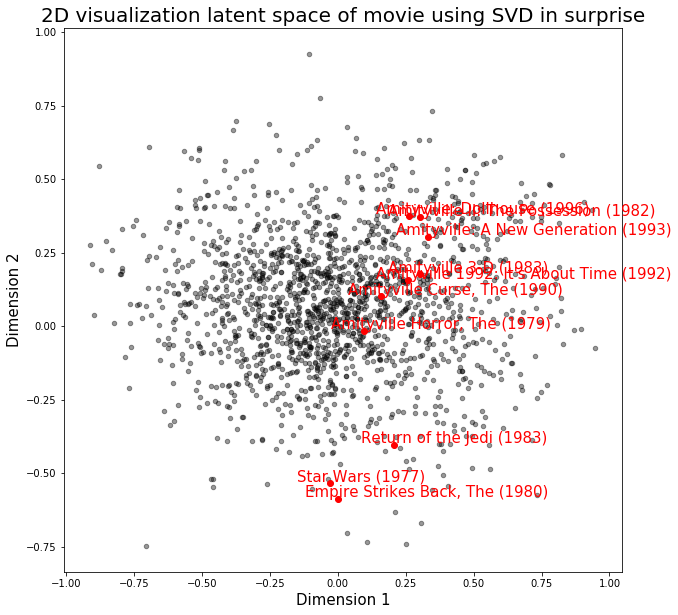

In [495]:
vis(movies,amityville_star_idex,V_h,1)

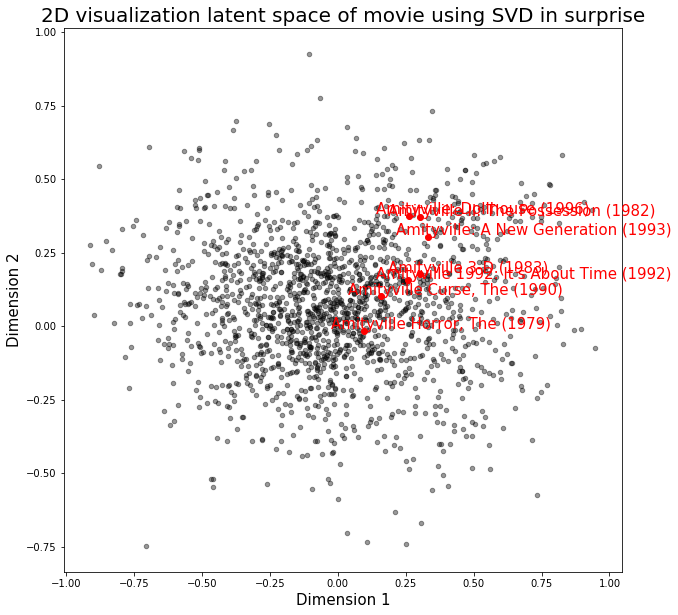

In [492]:
vis(movies,amityville_idx,V_h,1)

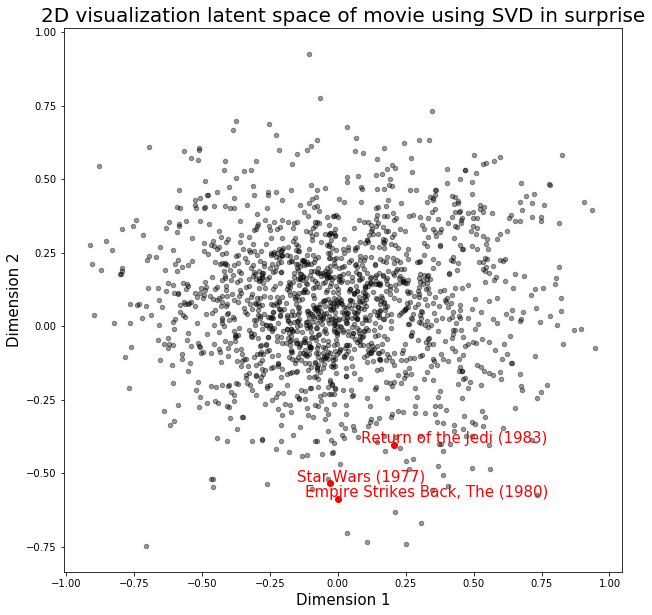

In [493]:
vis(movies,star_wars_idx,V_h,1)

In [487]:
movie_ids = np.array([861, 1421, 1586, 1661, 1380, 1334, 888, 361, 1647, 1])-1

Text(0.5, 1.0, 'Projections of Selected Movies')

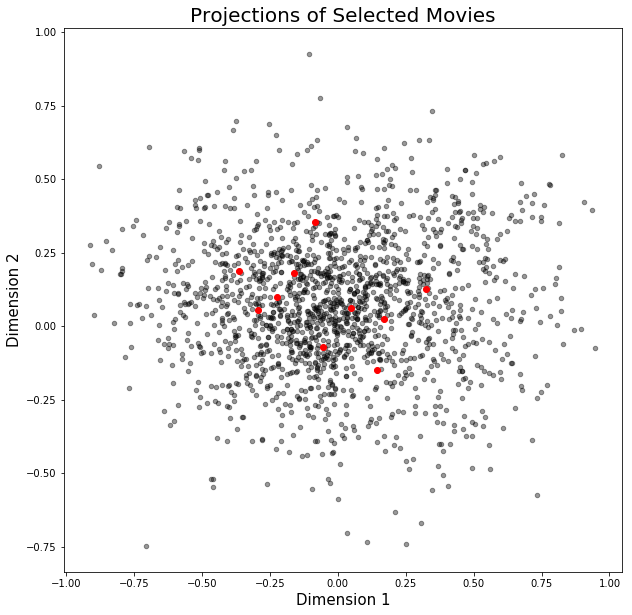

In [488]:
vis(movies,movie_ids,V_h,0)
plt.title('Projections of Selected Movies',fontsize=20)

Text(0.5, 1.0, 'Projections of Selected Movies')

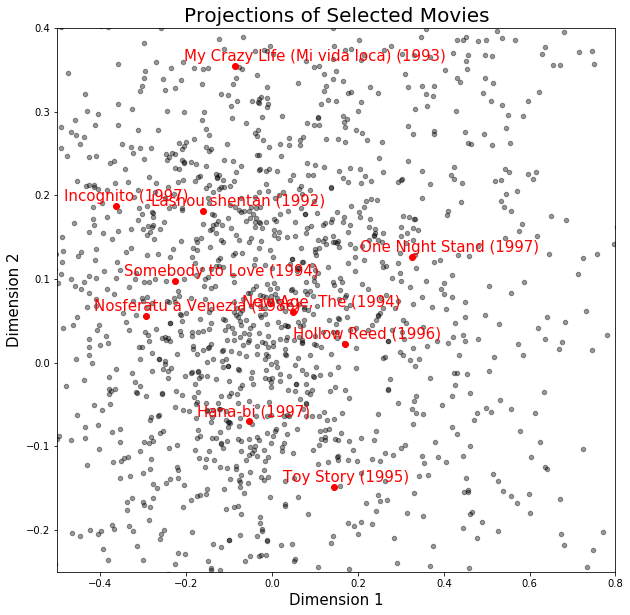

In [491]:
vis(movies,movie_ids,V_h,1)
plt.xlim([-0.5,0.8])
plt.ylim([-0.25,0.4])
plt.title('Projections of Selected Movies',fontsize=20)

In [466]:
n = 10
ids, counts = np.unique(data['Movie Id'], return_counts=True)
movie_ids = ids[np.argsort(counts)[-n:]]

# Find indices of selected movie IDs

In [467]:
movie_ids = movie_ids-1

Text(0.5, 1.0, 'Projections of Most Popular Movies')

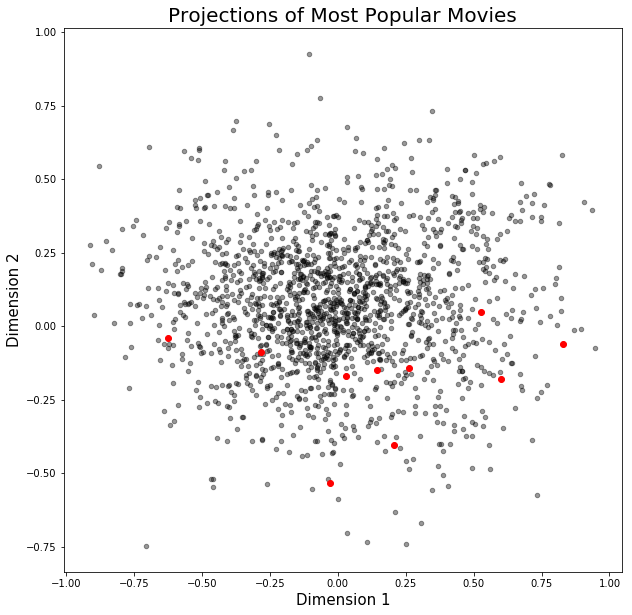

In [468]:
vis(movies,movie_ids,V_h,0)
plt.title('Projections of Most Popular Movies',fontsize=20)

(-0.6, 0.15)

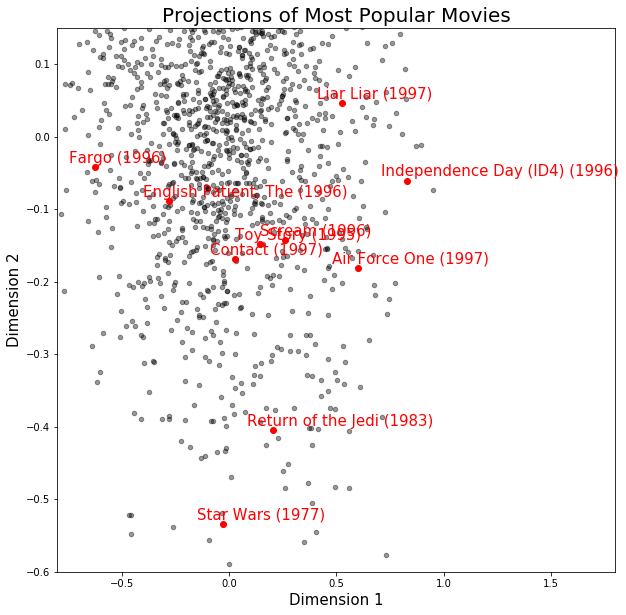

In [475]:
vis(movies,movie_ids,V_h,1)
plt.title('Projections of Most Popular Movies',fontsize=20)
plt.xlim([-0.8,1.8])
plt.ylim([-0.6,0.15])

In [476]:
# Extract IDs of best movies
n = 10
mean_ratings = data[['Movie Id', 'Rating']].groupby(
    'Movie Id').agg('mean').reset_index()
movie_ids = mean_ratings.sort_values(
    'Rating', ascending=False)['Movie Id'][:n]

movie_ids = movie_ids.values-1

In [477]:
movie_ids

array([ 813, 1598, 1200, 1121, 1652, 1292, 1499, 1188, 1535, 1466])

Text(0.5, 1.0, 'Projections of Best Movies')

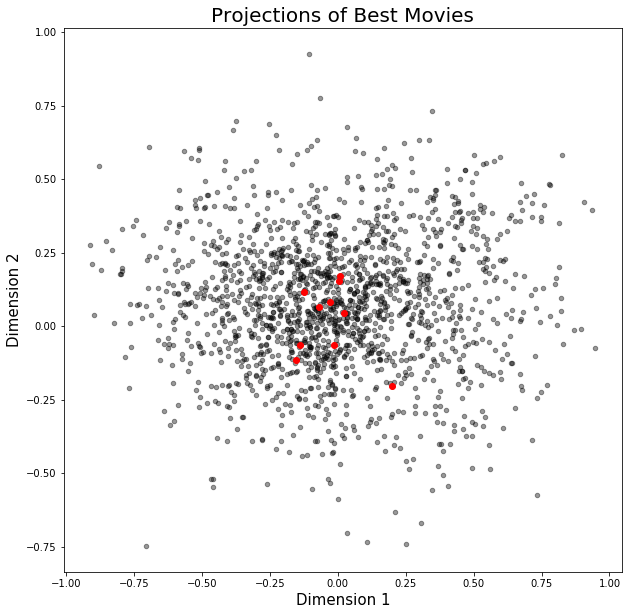

In [478]:
vis(movies,movie_ids,V_h,0)
plt.title('Projections of Best Movies',fontsize=20)

Text(0.5, 1.0, 'Projections of Best Movies')

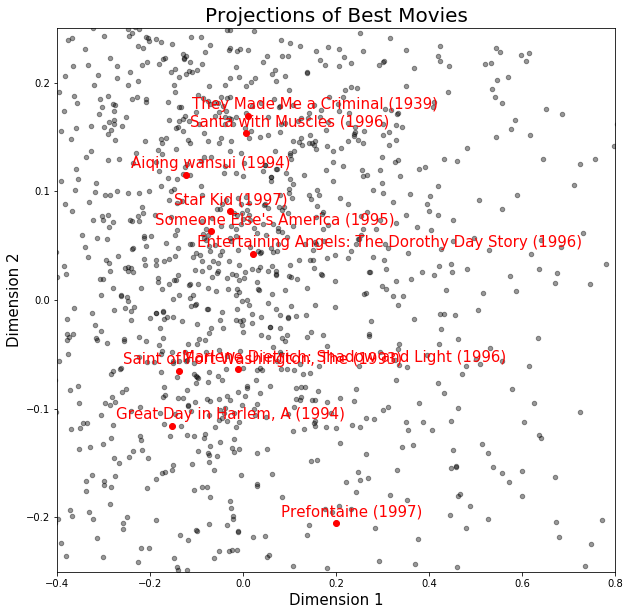

In [479]:
vis(movies,movie_ids,V_h,1)
plt.xlim([-0.4,0.8])
plt.ylim([-0.25,0.25])
plt.title('Projections of Best Movies',fontsize=20)

In [496]:
interest_index = amityville_star_idex

Text(0.5, 1.0, 'Projections of Selected Movies')

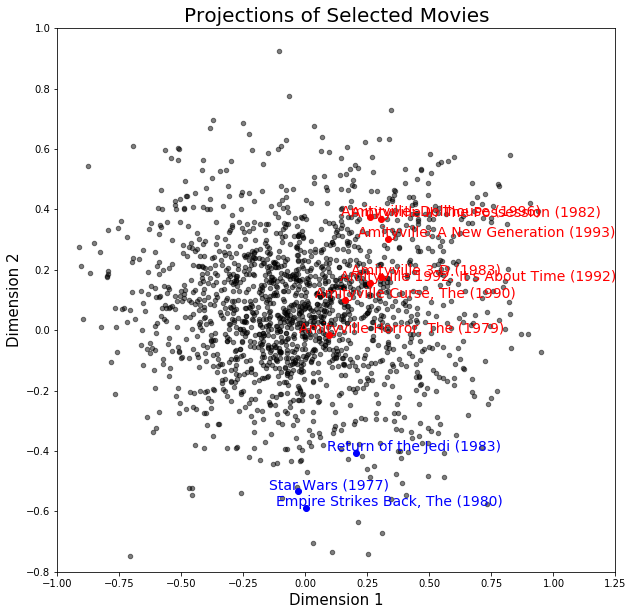

In [511]:
plt.figure(figsize=(10,10))
plt.scatter(V_h[0],V_h[1],s=20,color = 'black',alpha = 0.5)
plt.xlabel('Dimension 1',fontsize=15)
plt.ylabel('Dimension 2',fontsize=15)


for i in range(len(interest_index)):
    index = interest_index[i]
    movie_name = movies['Movie Title'][index]
    if i<=6: 
        plt.scatter(V_h[0,interest_index[i]],V_h[1,interest_index[i]],color = 'red')
        plt.text(V_h[0,int(interest_index[i])]-0.12,V_h[1,int(interest_index[i])]+0.006,
                 movie_name,
                 color = 'red',
                 fontsize=14)
    else:
        plt.scatter(V_h[0,interest_index[i]],V_h[1,interest_index[i]],color = 'blue')
        plt.text(V_h[0,int(interest_index[i])]-0.12,V_h[1,int(interest_index[i])]+0.006,
                 movie_name,
                 color = 'blue',
                 fontsize=14)
        
plt.xlim([-1,1.25])
plt.ylim([-0.8,1])
plt.title('Projections of Selected Movies',fontsize=20)

In [498]:
ax.scatter(V_h[0],V_h[1],s=20,color = 'black',alpha = 0.4)

Text(0.5, 1.0, 'Projections of Selected Movies')

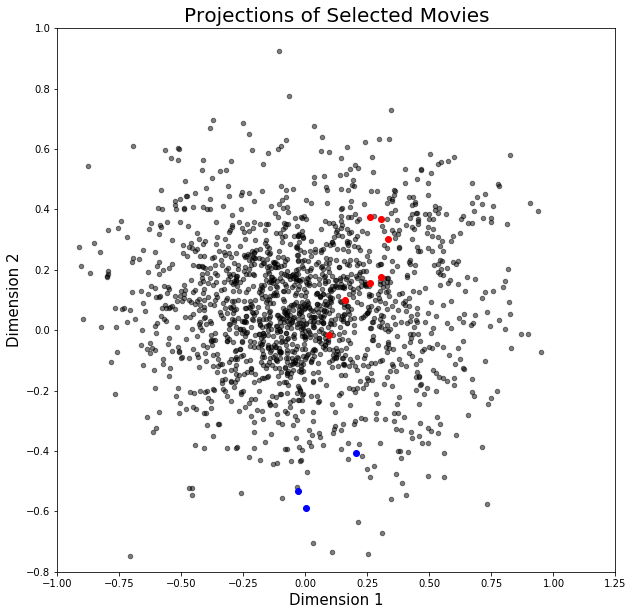

In [513]:
plt.figure(figsize=(10,10))
plt.scatter(V_h[0],V_h[1],s=20,color = 'black',alpha = 0.5)
plt.xlabel('Dimension 1',fontsize=15)
plt.ylabel('Dimension 2',fontsize=15)


for i in range(len(interest_index)):
    index = interest_index[i]
    movie_name = movies['Movie Title'][index]
    if i<=6: 
        plt.scatter(V_h[0,interest_index[i]],V_h[1,interest_index[i]],color = 'red')
        #plt.text(V_h[0,int(interest_index[i])]-0.12,V_h[1,int(interest_index[i])]+0.006,
                 #movie_name,
                 #color = 'red',
                 #fontsize=14)
    else:
        plt.scatter(V_h[0,interest_index[i]],V_h[1,interest_index[i]],color = 'blue')
        #plt.text(V_h[0,int(interest_index[i])]-0.12,V_h[1,int(interest_index[i])]+0.006,
                 #movie_name,
                 #color = 'blue',
                 #fontsize=14)
        
plt.xlim([-1,1.25])
plt.ylim([-0.8,1])
plt.title('Projections of Selected Movies',fontsize=20)

In [527]:
# Extract IDs of best movies
#n = 10
mean_ratings = data[['Movie Id', 'Rating']].groupby(
    'Movie Id').agg('mean').reset_index()
#movie_ids = mean_ratings.sort_values(
    #'Rating', ascending=False)['Movie Id'][:n]

#movie_ids = movie_ids.values-1

In [544]:
mean_ratings_vector = mean_ratings['Rating'].values
ids, counts = np.unique(data['Movie Id'], return_counts=True)

In [546]:
ids

array([   1,    2,    3, ..., 1680, 1681, 1682])

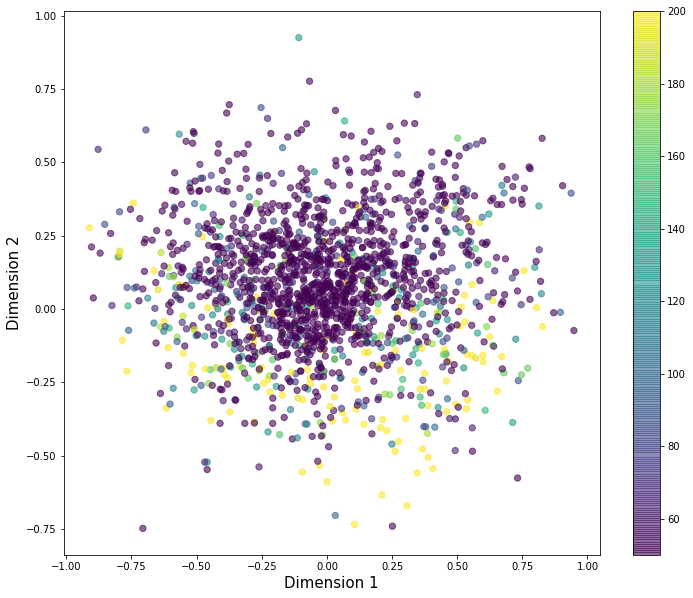

In [561]:
plt.figure(figsize=(12,10))
plt.scatter(V_h[0],V_h[1],c = counts,s=40,alpha = 0.6,vmin=50,vmax=200)
plt.xlabel('Dimension 1',fontsize=15)
plt.ylabel('Dimension 2',fontsize=15)
plt.colorbar()
plt.title('Numbers of rating',fontsize=15)